In [1]:
import pandas as pd
import numpy as np
import pdb
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
# from scipy.misc import imread
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as gbm
from sklearn.decomposition import PCA
import os
import pickle

%matplotlib nbagg

In [2]:
X = pd.read_csv('testX.csv', index_col=0)
X_train = pd.read_csv('TrainingData.csv', index_col=0)

c:\users\vasistha singhal\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# data = pd.read_csv('TrainingData.csv', index_col=0)
# X_data = data.drop('default_ind', axis=1)  
# y_data = data['default_ind']
# X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.125)

# X_train = pd.DataFrame.copy(X_train_data)
# X_train['default_ind']  = y_train_data

# X = X_test_data.copy()

In [4]:
def encoding(train_data,test_data=None):
    
    counts = train_data.groupby('mvar48')['default_ind'].count()
    means = train_data.groupby('mvar48')['default_ind'].mean()
    m = 0
    smooth_mean = (counts * means + m * train_data['mvar48'].mean()) / (counts + m)
    enc_48 = dict(smooth_mean)
    train_data['mvar48'] = train_data['mvar48'].map(enc_48)
    train_data = train_data.replace({'C':0,'L':1})
   
    test_data = test_data.replace({'C':0,'L':1})
    test_data['mvar48'] = test_data['mvar48'].map(enc_48)
    return train_data, test_data  

In [5]:
X.replace('missing', np.nan, inplace=True)
X.replace('na', np.nan, inplace=True)
int_cols = list(set(X.columns) - {'mvar47'})
X[int_cols] = X[int_cols].astype(float)

X_train.replace('missing', np.nan, inplace=True)
X_train.replace('na', np.nan, inplace=True)
int_cols = list(set(X_train.columns) - {'mvar47'})
X_train[int_cols] = X_train[int_cols].astype(float)

X_train_enc, X_enc = encoding(X_train,X)

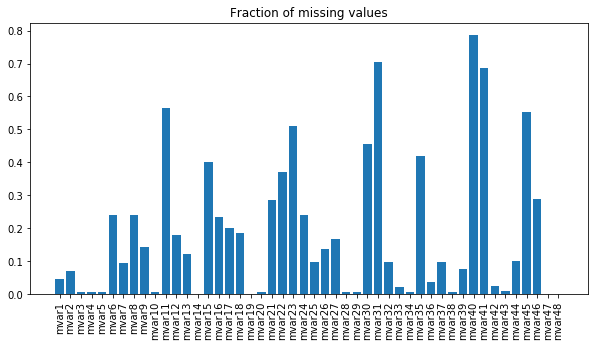

In [6]:
cols = list(X_enc.columns)
nan_per = X_enc.isna().sum(axis=0)/X_enc.shape[0]
plt.figure(figsize=(10,5))
plt.bar(cols,nan_per)
plt.xticks(rotation='vertical')
plt.title('Fraction of missing values')
plt.show()

In [7]:
initial_scaler = pickle.load(open('pre_KNN_scaler.sav', 'rb'))
X_scaled = pd.DataFrame(initial_scaler.transform(X_enc), columns = X_enc.columns, index=X_enc.index)

In [8]:
def basic_impute(data, cols, type_='mean'):
    
    if type_ == 'mean':
        return data.fillna(data[cols].mean()) 
    
    if type_ == 'median':
        return data.fillna(data[cols].median())
    
    if type_ =='mode':
        md = data[cols].mode()
        return data.fillna(md.iloc[0]) 
    
    if type_ == 'CF': #CF - Customer friendly
        imp_vals = data.mean()
        v = [40,31,41,45,35,46,24,16,17,18,12,9,39,2,42,43]
        for i in v:
            imp_vals['mvar'+str(i)] = 0
        med = data.median()
        imp_vals['mvar11'] = med['mvar11']
        
        return data.fillna(imp_vals[cols])

In [9]:
def KNN_impute(cols_to_impute, X, train_na_method='median'):
    
    result = X.copy()

    X_nonan = basic_impute(X, X.columns, type_=train_na_method)

    for col in cols_to_impute:

        X_train = X_nonan.loc[~X[col].isna()].drop(col, axis=1)
        y_train = X_nonan.loc[~X[col].isna(), col]

        X_test = X_nonan.loc[X[col].isna()].drop(col, axis=1)
        
        if len(X_test) == 0:
            print('No need to impute', col)
            continue
        
        print(col, ': Number of NaNs -', len(X_test))
        
        # 0.1 % of the data as neighbours
        model = KNeighborsRegressor(int(0.001*len(X_train)))
        model.fit(X_train, y_train)

        result.loc[X_test.index, col] = model.predict(X_test)
        
        print('Imputed for', col)
        
    return result

In [10]:
X_scaled_imputed = KNN_impute(X_scaled.columns, X_scaled, train_na_method='median')
X_rescaled = pd.DataFrame(initial_scaler.inverse_transform(X_scaled_imputed), columns=X_scaled_imputed.columns, index=X_scaled_imputed.index)

mvar1 : Number of NaNs - 2228
Imputed for mvar1
mvar2 : Number of NaNs - 3327
Imputed for mvar2
mvar3 : Number of NaNs - 294
Imputed for mvar3
mvar4 : Number of NaNs - 294
Imputed for mvar4
mvar5 : Number of NaNs - 294
Imputed for mvar5
mvar6 : Number of NaNs - 11297
Imputed for mvar6
mvar7 : Number of NaNs - 4479
Imputed for mvar7
mvar8 : Number of NaNs - 11302
Imputed for mvar8
mvar9 : Number of NaNs - 6812
Imputed for mvar9
mvar10 : Number of NaNs - 295
Imputed for mvar10
mvar11 : Number of NaNs - 26518
Imputed for mvar11
mvar12 : Number of NaNs - 8397
Imputed for mvar12
mvar13 : Number of NaNs - 5807
Imputed for mvar13
No need to impute mvar14
mvar15 : Number of NaNs - 18836
Imputed for mvar15
mvar16 : Number of NaNs - 11033
Imputed for mvar16
mvar17 : Number of NaNs - 9432
Imputed for mvar17
mvar18 : Number of NaNs - 8785
Imputed for mvar18
mvar19 : Number of NaNs - 7
Imputed for mvar19
mvar20 : Number of NaNs - 295
Imputed for mvar20
mvar21 : Number of NaNs - 13380
Imputed for mv

In [11]:
def col_creator(cols_list, X):
    y = X.copy()
    columns = X.columns
    for i in range(len(columns)):
        f1 = columns[i]
        if f1=='mvar47':
            continue
        for j in range(i):
            f2 = columns[j]
            if f2=='mvar47':
                continue
            if str(f1) + '*' + str(f2) in cols_list or str(f2) + '*' + str(f1) in cols_list:
                y[str(f1)+'*'+str(f2)] = X[f1]*X[f2]
    return y

In [12]:
col_list = pickle.load(open('cols_list.sav', 'rb'))
X_inter = col_creator(col_list, X_rescaled)
X_inter.describe()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar48*mvar34,mvar48*mvar35,mvar48*mvar36,mvar48*mvar37,mvar48*mvar38,mvar48*mvar39,mvar48*mvar42,mvar48*mvar43,mvar48*mvar44,mvar48*mvar46
count,47000.000000,47000.000000,47000.000000,47000.000000,4.700000e+04,47000.000000,4.700000e+04,47000.000000,4.700000e+04,4.700000e+04,...,4.700000e+04,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,4.700000e+04,47000.000000,47000.000000,47000.000000
mean,1742.722986,1.079593,5.337719,0.455771,1.115285e+00,1487.051601,1.674842e+04,5632.693128,3.037784e+04,3.108487e+04,...,6.546261e-02,0.070940,1.787222,1.164540,1.212376,0.025735,9.849718e-02,1.852716,0.207485,0.020019
std,96.007464,1.656391,11.004566,1.802979,6.064693e+00,3329.088778,4.801932e+04,9372.432312,5.220191e+04,6.830341e+04,...,1.939260e-01,0.144556,1.525478,1.316958,1.153803,0.117467,1.118705e-01,1.825213,0.073689,0.084405
min,1494.000000,0.000000,0.000000,0.000000,-5.551115e-16,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.637979e-12,...,-2.775558e-17,0.000000,0.000000,0.000000,0.000000,0.000000,-3.851118e-17,0.000000,0.000000,0.000000
25%,1673.000000,0.139472,0.000000,0.000000,0.000000e+00,86.000000,1.789685e+03,668.000000,2.336388e+03,1.093000e+03,...,-8.606817e-18,0.000000,0.797717,0.265906,0.493703,0.000000,0.000000e+00,0.512183,0.151792,0.000000
50%,1738.000000,0.529300,0.310000,0.000000,0.000000e+00,496.000000,5.992000e+03,1692.714286,9.991337e+03,9.496500e+03,...,-7.578595e-18,0.000000,1.387511,0.746046,0.930280,0.000000,5.781413e-02,1.365238,0.217192,0.000000
75%,1808.732955,1.370900,6.448500,0.000000,0.000000e+00,1240.228571,1.670725e+04,6640.000000,3.765800e+04,3.462850e+04,...,-6.902309e-18,0.082371,2.262912,1.697184,1.638286,0.000000,1.669728e-01,2.735501,0.264512,0.000000
max,1950.000000,44.630100,286.858000,114.696000,2.265270e+02,136595.000000,5.549600e+06,266683.000000,3.711880e+06,5.633320e+06,...,4.856290e+00,2.545776,27.288209,20.812670,30.483888,4.153605,1.200000e+00,29.200356,0.705323,5.374417


In [13]:
scaler = pickle.load(open('post_KNN_scaler.sav', 'rb'))
X_inter_scaled = pd.DataFrame(scaler.transform(X_inter), columns=X_inter.columns, index=X_inter.index)

In [14]:
pca = pickle.load(open('PCA.sav', 'rb'))
X_test_pca = pd.DataFrame(pca.transform(X_inter_scaled), index=X_inter_scaled.index)

In [15]:
def predict(test_data, models, thresh, weights=None):
    
    if weights == None:
        weights = np.ones(len(models))
    
    N = len(models)
    ypred_final = np.zeros(test_data.shape[0])
    
    for i in range(N):
        if thresh[i]==None:
            print('Using XGBoost')
            ypred_final += weights[i]*models[i].predict(test_data)
        
        else:
            print('Using LightBoost with Threshold =', thresh[i])
            y_test_prob = models[i].predict(test_data)    
            y_pred_test = np.zeros(len(y_test_prob))
            y_pred_test[np.argwhere(y_test_prob>thresh[i])] = 1 
            
            ypred_final += weights[i]*y_pred_test
            
       
    ypred_final = ypred_final/sum(weights)
    
    y_hat_test = np.zeros(test_data.shape[0])
    y_hat_test[np.argwhere(ypred_final>0.5)] = 1
    
    y = pd.DataFrame(y_hat_test, index=test_data.index)
    
    return y

In [16]:
models = pickle.load(open('models.sav', 'rb'))
thresholds = pickle.load(open('thresholds.sav', 'rb'))
y_hat_test = predict(X_test_pca, models, thresh = thresholds) ##Get t from grid search 

Using LightBoost with Threshold = 0.5
Using LightBoost with Threshold = 0.5
Using XGBoost
Using LightBoost with Threshold = 0.5
Using LightBoost with Threshold = 0.5
Using LightBoost with Threshold = 0.5
Using LightBoost with Threshold = 0.6
Using LightBoost with Threshold = 0.6
Using LightBoost with Threshold = 0.6
Using LightBoost with Threshold = 0.6
Using LightBoost with Threshold = 0.6
Using LightBoost with Threshold = 0.45
Using LightBoost with Threshold = 0.45
Using XGBoost
Using LightBoost with Threshold = 0.45
Using LightBoost with Threshold = 0.45
Using XGBoost
Using LightBoost with Threshold = 0.5
Using XGBoost
Using LightBoost with Threshold = 0.5


In [17]:
y_hat_test.to_csv('Predictions.csv')